In [1]:
import os
import sklearn
import pandas as pd
import keras_tuner as kt
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam, RMSprop, SGD
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,root_mean_squared_error, mean_absolute_error

In [2]:
data = pd.read_csv('data.csv')

X_test = pd.read_csv('X_test.csv')
X_train = pd.read_csv('X_train.csv')
y_test = pd.read_csv('y_test.csv')
y_train = pd.read_csv('y_train.csv')

In [3]:
data.describe()

,Cycle,Fade_percentage,Current_capacity,Nominal_capacity,SOH,Capacity,Ambient_temperature,Voltage_mean,Voltage_max,Temperature_mean,Temperature_max,Time_at_max_temp,Discharge_duration
count,1251.000000,1251.000000,1251.000000,1251.0,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000
mean,83.024780,25.883293,1.482334,2.0,0.436869,0.436869,18.964029,0.522170,0.575790,0.489753,0.535943,0.464433,2922.221988
std,50.126067,4.923329,0.098467,0.0,0.272801,0.272801,8.684394,0.270516,0.247367,0.243795,0.255585,0.268705,309.809435
min,1.000000,20.000000,1.400000,2.0,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2295.109000
25%,41.000000,20.000000,1.400000,2.0,0.206600,0.206600,4.000000,0.296600,0.385300,0.306500,0.342200,0.227850,2752.383000
50%,77.000000,30.000000,1.400000,2.0,0.402200,0.402200,24.000000,0.526700,0.562100,0.484500,0.569900,0.451800,2998.125000
75%,119.000000,30.000000,1.600000,2.0,0.653700,0.653700,24.000000,0.742550,0.793250,0.670050,0.735700,0.678250,3151.047000
max,197.000000,30.000000,1.600000,2.0,1.000000,1.000000,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3690.234000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1251 entries, 0 to 1250
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Battery              1251 non-null   object 
 1   Cycle                1251 non-null   int64  
 2   Fade_percentage      1251 non-null   int64  
 3   Current_capacity     1251 non-null   float64
 4   Nominal_capacity     1251 non-null   int64  
 5   SOH                  1251 non-null   float64
 6   Capacity             1251 non-null   float64
 7   Ambient_temperature  1251 non-null   int64  
 8   Voltage_mean         1251 non-null   float64
 9   Voltage_max          1251 non-null   float64
 10  Temperature_mean     1251 non-null   float64
 11  Temperature_max      1251 non-null   float64
 12  Time_at_max_temp     1251 non-null   float64
 13  Discharge_duration   1251 non-null   float64
dtypes: float64(9), int64(4), object(1)
memory usage: 137.0+ KB


In [5]:
X_train.info()
X_test.info()
y_train.info() 
y_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cycle               1000 non-null   int64  
 1   Voltage_mean        1000 non-null   float64
 2   Temperature_max     1000 non-null   float64
 3   Time_at_max_temp    1000 non-null   float64
 4   Discharge_duration  1000 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 39.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cycle               251 non-null    int64  
 1   Voltage_mean        251 non-null    float64
 2   Temperature_max     251 non-null    float64
 3   Time_at_max_temp    251 non-null    float64
 4   Discharge_duration  251 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 9.9 KB
<cla

In [ ]:
# y_train_ = y_train.to_frame()
# y_test_ = y_test.to_frame()

In [6]:
print("Data shape",data.shape,"\n")
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

Data shape (1251, 14) 

X_train shape (1000, 5)
y_train shape (1000, 1)
X_test shape (251, 5)
y_test shape (251, 1)


In [7]:
# Convert X_train and X_test to NumPy arrays
X_train_np = X_train.values
X_test_np = X_test.values

X_train_lstm = X_train_np.reshape((X_train_np.shape[0], 1, X_train_np.shape[1]))  # Reshape to 3D for LSTM
X_test_lstm = X_test_np.reshape((X_test_np.shape[0], 1, X_test_np.shape[1]))

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))) # Input layer
lstm_model.add(Dense(10)) # Hidden layer
lstm_model.add(Dense(units=1)) # Output layer

lstm_model.compile(optimizer='adam', loss='mse',metrics=['mae'])

In [68]:
early_stopping = EarlyStopping(patience=3)

In [69]:
history = lstm_model.fit(X_train_lstm, y_train, epochs=30, batch_size=32, validation_data=(X_test_lstm, y_test),callbacks=[early_stopping])

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0534 - mae: 0.1896 - val_loss: 0.0306 - val_mae: 0.1442
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0310 - mae: 0.1452 - val_loss: 0.0248 - val_mae: 0.1321
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0295 - mae: 0.1408 - val_loss: 0.0246 - val_mae: 0.1300
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0272 - mae: 0.1344 - val_loss: 0.0248 - val_mae: 0.1298
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0267 - mae: 0.1350 - val_loss: 0.0256 - val_mae: 0.1306
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0261 - mae: 0.1324 - val_loss: 0.0270 - val_mae: 0.1323


In [70]:
y_pred_lstm = lstm_model.predict(X_test_lstm)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [72]:
# Flatten predictions and true values to match dimensions
y_pred_lstm_flat = y_pred_lstm.flatten()
y_test_flat = y_test.values.flatten()

# Evaluate the model performance
mae_lstm = mean_absolute_error(y_test_flat, y_pred_lstm_flat)
mse_lstm = mean_squared_error(y_test_flat, y_pred_lstm_flat)
rmse_lstm = root_mean_squared_error(y_test_flat, y_pred_lstm_flat)

print(f'MAE: {mae_lstm:.4f}')
print(f'MSE: {mse_lstm:.4f}')
print(f'RMSE: {rmse_lstm:.4f}')

MAE: 0.1323
MSE: 0.0270
RMSE: 0.1643


In [73]:
if isinstance(y_test, pd.DataFrame) or isinstance(y_test, pd.Series):
    y_test = y_test.values

y_pred_lstm_flat = y_pred_lstm.flatten()
y_test_flat = y_test.flatten()

results_lstm = pd.DataFrame({'Actual SOH': y_test_flat, 'Predicted SOH': y_pred_lstm_flat.round(4)})
print(results_lstm)

     Actual SOH  Predicted SOH
0        0.1231         0.2236
1        0.3744         0.2446
2        0.1782         0.2353
3        0.4869         0.2234
4        0.3438         0.6919
..          ...            ...
246      0.7323         0.7053
247      0.2741         0.2234
248      0.2306         0.2276
249      0.1856         0.3139
250      0.2840         0.2235

[251 rows x 2 columns]


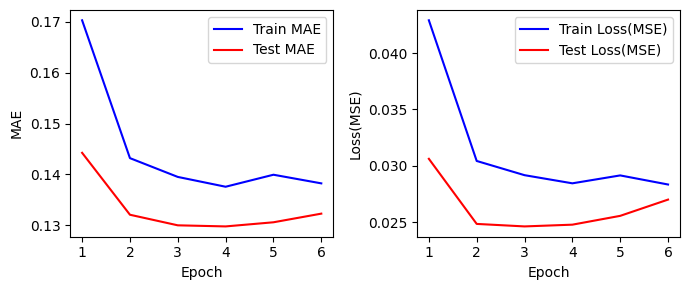

In [74]:
acc2 = history.history['mae']
val_acc = history.history['val_mae']
loss2 = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc2)+1)

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

axes[0].plot(epochs, acc2,'b',label='Train MAE')
axes[0].plot(epochs, val_acc,'r',label='Test MAE')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].legend()

axes[1].plot(epochs, loss2,'b',label='Train Loss(MSE)')
axes[1].plot(epochs, val_loss,'r',label='Test Loss(MSE)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss(MSE)')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

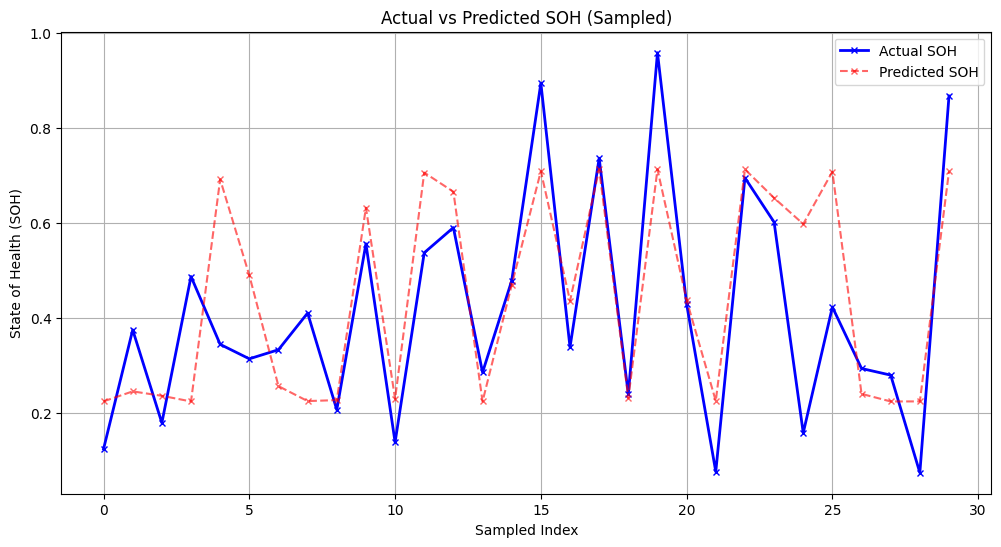

In [75]:
sample_size = 30  
y_test_sample = y_test[:sample_size]
y_pred_sample = y_pred_lstm[:sample_size]
y_pred_sample_flat = y_pred_sample.flatten()

plt.figure(figsize=(12, 6))
plt.plot(y_test_sample, label='Actual SOH', color='blue',marker='x', markersize=5, linewidth=2)
plt.plot(y_pred_sample_flat, label='Predicted SOH', color='red', linestyle='--', marker='x', markersize=5, alpha=0.6)
plt.title('Actual vs Predicted SOH (Sampled)')
plt.xlabel('Sampled Index')
plt.ylabel('State of Health (SOH)')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
import torch

if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [17]:
# import torch

# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(device))
else:
    device = torch.device("cpu")
    print("Using CPU")

# Create a tensor and move it to the selected device
x = torch.randn(10, 10).to(device)

# Check if the tensor is on the GPU
if x.is_cuda:
    print("Tensor is on the GPU")
else:
    print("Tensor is on the CPU")

Using GPU: NVIDIA GeForce MX130
Tensor is on the GPU


In [18]:
data.isnull().sum()

Battery                0
Cycle                  0
Fade_percentage        0
Current_capacity       0
Nominal_capacity       0
SOH                    0
Capacity               0
Ambient_temperature    0
Voltage_mean           0
Voltage_max            0
Temperature_mean       0
Temperature_max        0
Time_at_max_temp       0
Discharge_duration     0
dtype: int64

**# Hyperband Tuning, 1 Hidden Layer**

In [77]:
def build_model(hp):
    # Define hyperparameters using `hp`
    units1 = hp.Int('units1', min_value=50, max_value=150, step=10)  # LSTM units
    units2 = hp.Int('units2', min_value=10, max_value=100, step=10)  # Dense units
    activation_1 = hp.Choice('activation_1', values=['relu', 'tanh']) # Activation function
    batch_size = hp.Choice('batch_size', values=[16, 32, 64])
    dropout = hp.Choice('dropout', values=[0.0, 0.2, 0.3])  # Dropout rate
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])  # Optimizer
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])  # Learning rate

    model = Sequential()
    model.add(LSTM(units=units1, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(Dense(units=units2, activation=activation_1))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)
        
    # Compile with the selected optimizer and learning rate
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [78]:
tuner = kt.Hyperband(build_model,
                    objective='val_loss',
                    max_epochs=50,
                    factor=3,
                    directory='my_dir',
                    project_name='hyperband_1hidden_lstm')

c:\Users\hp\Documents\FYP\dashboard\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [79]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
hyperband = tuner.search(X_train_lstm, y_train, validation_data=(X_test_lstm, y_test),callbacks=[early_stopping])

Trial 85 Complete [00h 00m 11s]
val_loss: 0.07499080896377563

Best val_loss So Far: 0.023294005542993546
Total elapsed time: 00h 16m 51s


In [80]:
# Get the best hyperparameter
best_lstm_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print('Best LSTM hyperparameters:', best_lstm_hps.values)

Best LSTM hyperparameters: {'units1': 90, 'units2': 80, 'activation_1': 'relu', 'batch_size': 64, 'dropout': 0.0, 'optimizer': 'adam', 'learning_rate': 0.001, 'tuner/epochs': 17, 'tuner/initial_epoch': 6, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0060'}


In [81]:
best_lstm_model = tuner.hypermodel.build(best_lstm_hps)

history = best_lstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=best_lstm_hps.get('batch_size'),validation_data=(X_test_lstm, y_test), callbacks=[early_stopping])

Epoch 1/100


c:\Users\hp\Documents\FYP\dashboard\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.7746 - mae: 0.7616 - val_loss: 0.1635 - val_mae: 0.3442
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1361 - mae: 0.3115 - val_loss: 0.0791 - val_mae: 0.2319
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0810 - mae: 0.2314 - val_loss: 0.0751 - val_mae: 0.2349
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0696 - mae: 0.2266 - val_loss: 0.0446 - val_mae: 0.1772
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0416 - mae: 0.1723 - val_loss: 0.0307 - val_mae: 0.1456
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0309 - mae: 0.1474 - val_loss: 0.0260 - val_mae: 0.1341
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0263 - mae: 0.1341 - val_loss: 0.0255 - val_mae: 0.1302
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0258 - mae: 0.1325 - val_loss: 0.0257 - val_mae: 0.1338
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0293 - mae: 0.

In [82]:
y_pred_lstm = best_lstm_model.predict(X_test_lstm)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [83]:
y_pred_lstm_flat = y_pred_lstm.flatten()
y_test_flat = y_test.values.flatten()

mae_lstm = mean_absolute_error(y_test_flat, y_pred_lstm_flat)
mse_lstm = mean_squared_error(y_test_flat, y_pred_lstm_flat)
rmse_lstm = root_mean_squared_error(y_test_flat, y_pred_lstm_flat)

print(f'MAE: {mae_lstm:.4f}')
print(f'MSE: {mse_lstm:.4f}')
print(f'RMSE: {rmse_lstm:.4f}')

MAE: 0.1276
MSE: 0.0233
RMSE: 0.1526


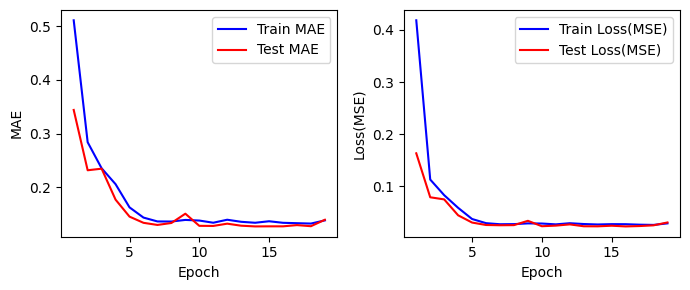

In [84]:
acc2 = history.history['mae']
val_acc = history.history['val_mae']
loss2 = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc2)+1)

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

axes[0].plot(epochs, acc2,'b',label='Train MAE')
axes[0].plot(epochs, val_acc,'r',label='Test MAE')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].legend()

axes[1].plot(epochs, loss2,'b',label='Train Loss(MSE)')
axes[1].plot(epochs, val_loss,'r',label='Test Loss(MSE)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss(MSE)')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [85]:
# Ensure y_test is a NumPy array (if it's a DataFrame or Series)
if isinstance(y_test, pd.DataFrame) or isinstance(y_test, pd.Series):
    y_test = y_test.values

# Ensure y_pred_ann is 1-dimensional
y_pred_lstm_flat = y_pred_lstm.flatten()

# Ensure y_test is also 1-dimensional if it isn't already
y_test_flat = y_test.flatten()

# Create a DataFrame to hold actual and predicted values
results_lstm = pd.DataFrame({'Actual SOH': y_test_flat, 'Predicted SOH': y_pred_lstm_flat.round(4)})

# Print the actual and predicted SOH values
print(results_lstm)

     Actual SOH  Predicted SOH
0        0.1231         0.2152
1        0.3744         0.2281
2        0.1782         0.2231
3        0.4869         0.2150
4        0.3438         0.6357
..          ...            ...
246      0.7323         0.6736
247      0.2741         0.2150
248      0.2306         0.2177
249      0.1856         0.2537
250      0.2840         0.2151

[251 rows x 2 columns]


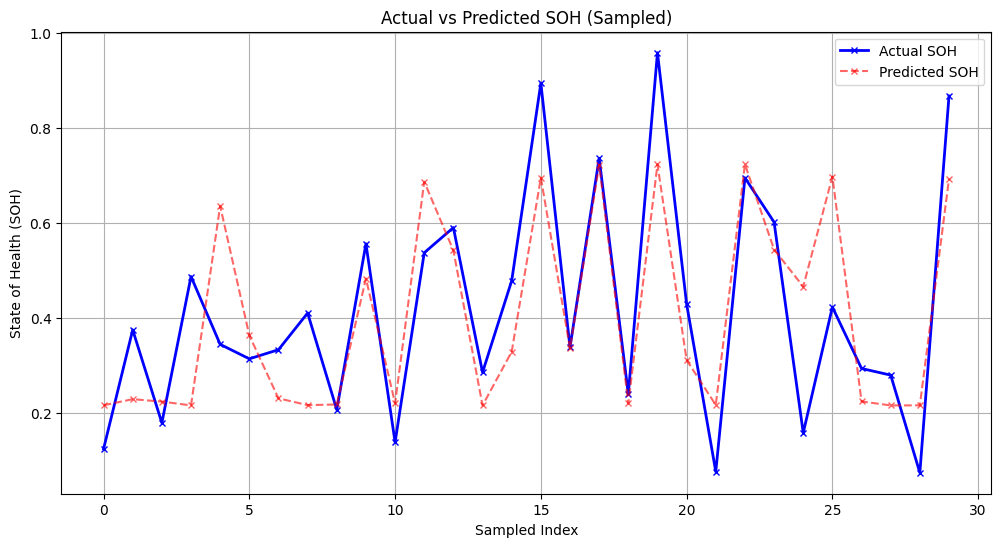

In [86]:
# Sample data for clearer visualization if the dataset is large
sample_size = 30  # adjust sample size as needed
y_test_sample = y_test[:sample_size]
y_pred_sample = y_pred_lstm[:sample_size]

y_pred_sample_flat = y_pred_sample.flatten()

# Plot actual and predicted SOH with transparency and markers
plt.figure(figsize=(12, 6))
plt.plot(y_test_sample, label='Actual SOH', color='blue',marker='x', markersize=5, linewidth=2)
plt.plot(y_pred_sample_flat, label='Predicted SOH', color='red', linestyle='--', marker='x', markersize=5, alpha=0.6)
plt.title('Actual vs Predicted SOH (Sampled)')
plt.xlabel('Sampled Index')
plt.ylabel('State of Health (SOH)')
plt.legend()
plt.grid(True)
plt.show()

**# Hyperband Tuning, 2 Hidden Layer**

In [87]:
def build_model(hp):
    # Define hyperparameters using `hp`
    units1 = hp.Int('units1', min_value=50, max_value=150, step=10)  # LSTM units
    units2 = hp.Int('units2', min_value=10, max_value=100, step=10)  # Dense units, hidden 1
    units3 = hp.Int('units3', min_value=10, max_value=100, step=10)  # Dense units, hidden 2
    activation_1 = hp.Choice('activation_1', values=['relu', 'tanh']) # Activation function
    activation_2 = hp.Choice('activation_2', values=['relu', 'tanh']) # Activation function
    batch_size = hp.Choice('batch_size', values=[16, 32, 64])
    dropout1 = hp.Choice('dropout1', values=[0.0, 0.2, 0.3])  # Dropout rate 1
    dropout2 = hp.Choice('dropout2', values=[0.0, 0.2, 0.3])  # Dropout rate 2
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])  # Optimizer
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])  # Learning rate

    model = Sequential()
    model.add(LSTM(units=units1, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(Dense(units=units2, activation=activation_1))
    model.add(Dropout(dropout1))
    model.add(Dense(units=units3, activation=activation_2))
    model.add(Dropout(dropout2))
    model.add(Dense(1))

    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)
    
    # Compile with the selected optimizer and learning rate
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [88]:
tuner = kt.Hyperband(build_model,
                    objective='val_loss', # MSE
                    max_epochs=50,
                    factor=3,
                    directory='my_dir',
                    project_name='hyperband_2hidden_lstm')

c:\Users\hp\Documents\FYP\dashboard\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [89]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
hyperband = tuner.search(X_train_lstm, y_train, validation_data=(X_test_lstm, y_test),
                         callbacks=[early_stopping])

Trial 87 Complete [00h 00m 12s]
val_loss: 0.0750952810049057

Best val_loss So Far: 0.02529560960829258
Total elapsed time: 00h 17m 33s


In [90]:
# Get the best hyperparameter
best_lstm_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print('Best LSTM hyperparameters:', best_lstm_hps.values)

Best LSTM hyperparameters: {'units1': 110, 'units2': 60, 'units3': 30, 'activation_1': 'relu', 'activation_2': 'tanh', 'batch_size': 32, 'dropout1': 0.2, 'dropout2': 0.3, 'optimizer': 'adam', 'learning_rate': 0.001, 'tuner/epochs': 50, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [92]:
best_lstm_model = tuner.hypermodel.build(best_lstm_hps)

history = best_lstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=best_lstm_hps.get('batch_size'),validation_data=(X_test_lstm, y_test), callbacks=[early_stopping])

Epoch 1/100


c:\Users\hp\Documents\FYP\dashboard\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.4938 - mae: 0.5657 - val_loss: 0.0621 - val_mae: 0.2164
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1544 - mae: 0.3121 - val_loss: 0.0451 - val_mae: 0.1793
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0882 - mae: 0.2414 - val_loss: 0.0386 - val_mae: 0.1668
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0663 - mae: 0.2093 - val_loss: 0.0379 - val_mae: 0.1616
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0609 - mae: 0.1956 - val_loss: 0.0460 - val_mae: 0.1863
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0514 - mae: 0.1848 - val_loss: 0.0297 - val_mae: 0.1427
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0444 - mae: 0.1728 - val_loss: 0.0285 - val_mae: 0.1397
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0414 - mae: 0.1625 - val_loss: 0.0268 - val_mae: 0.1384
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0349 - mae: 0.

In [93]:
y_pred_lstm = best_lstm_model.predict(X_test_lstm)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


In [94]:
# Flatten predictions and true values to match dimensions
y_pred_lstm_flat = y_pred_lstm.flatten()
y_test_flat = y_test.values.flatten()

# Evaluate the model performance
mae_lstm = mean_absolute_error(y_test_flat, y_pred_lstm_flat)
mse_lstm = mean_squared_error(y_test_flat, y_pred_lstm_flat)
rmse_lstm = root_mean_squared_error(y_test_flat, y_pred_lstm_flat)

print(f'MAE: {mae_lstm:.4f}')
print(f'MSE: {mse_lstm:.4f}')
print(f'RMSE: {rmse_lstm:.4f}')

MAE: 0.1384
MSE: 0.0268
RMSE: 0.1637


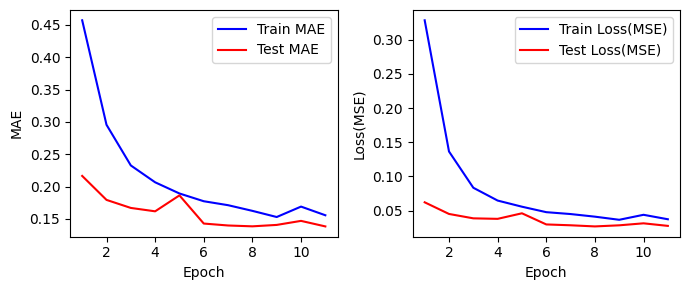

In [95]:
acc2 = history.history['mae']
val_acc = history.history['val_mae']
loss2 = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc2)+1)

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

axes[0].plot(epochs, acc2,'b',label='Train MAE')
axes[0].plot(epochs, val_acc,'r',label='Test MAE')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].legend()

axes[1].plot(epochs, loss2,'b',label='Train Loss(MSE)')
axes[1].plot(epochs, val_loss,'r',label='Test Loss(MSE)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss(MSE)')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [96]:
# Ensure y_test is a NumPy array (if it's a DataFrame or Series)
if isinstance(y_test, pd.DataFrame) or isinstance(y_test, pd.Series):
    y_test = y_test.values

# Ensure y_pred_ann is 1-dimensional
y_pred_lstm_flat = y_pred_lstm.flatten()

# Ensure y_test is also 1-dimensional if it isn't already
y_test_flat = y_test.flatten()

# Create a DataFrame to hold actual and predicted values
results_lstm = pd.DataFrame({'Actual SOH': y_test_flat, 'Predicted SOH': y_pred_lstm_flat.round(4)})

# Print the actual and predicted SOH values
print(results_lstm)

     Actual SOH  Predicted SOH
0        0.1231         0.2333
1        0.3744         0.2398
2        0.1782         0.2373
3        0.4869         0.2333
4        0.3438         0.6041
..          ...            ...
246      0.7323         0.6245
247      0.2741         0.2333
248      0.2306         0.2344
249      0.1856         0.2535
250      0.2840         0.2333

[251 rows x 2 columns]


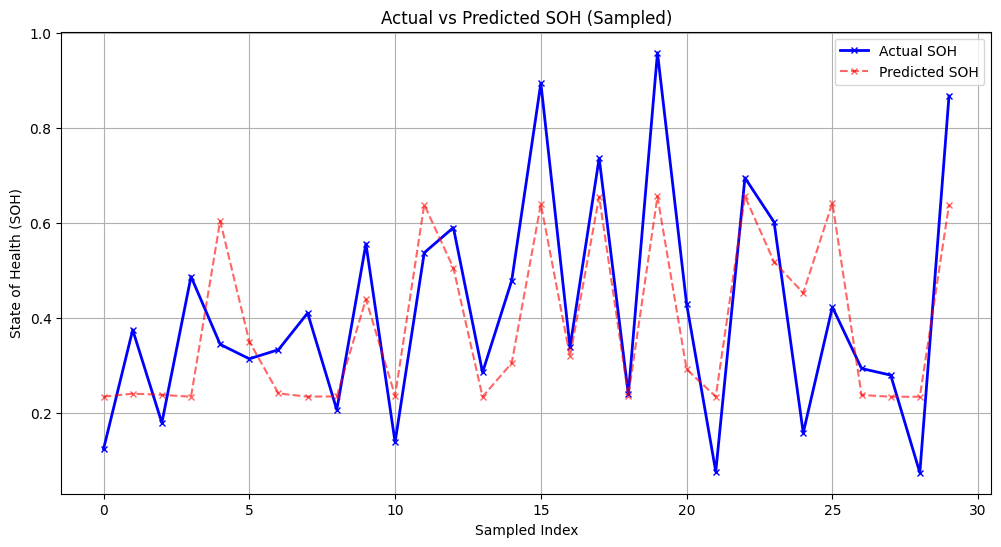

In [97]:
# Sample data for clearer visualization if the dataset is large
sample_size = 30  # adjust sample size as needed
y_test_sample = y_test[:sample_size]
y_pred_sample = y_pred_lstm[:sample_size]

y_pred_sample_flat = y_pred_sample.flatten()

# Plot actual and predicted SOH with transparency and markers
plt.figure(figsize=(12, 6))
plt.plot(y_test_sample, label='Actual SOH', color='blue',marker='x', markersize=5, linewidth=2)
plt.plot(y_pred_sample_flat, label='Predicted SOH', color='red', linestyle='--', marker='x', markersize=5, alpha=0.6)
plt.title('Actual vs Predicted SOH (Sampled)')
plt.xlabel('Sampled Index')
plt.ylabel('State of Health (SOH)')
plt.legend()
plt.grid(True)
plt.show()

**# Hyperband Tuning, 3 Hidden Layer**

In [98]:
def build_model(hp):
    units1 = hp.Int('units1', min_value=50, max_value=150, step=10)  # LSTM units
    units2 = hp.Int('units2', min_value=10, max_value=100, step=10)  # Dense units, hidden 1
    units3 = hp.Int('units3', min_value=10, max_value=100, step=10)  # Dense units, hidden 2
    units4 = hp.Int('units4', min_value=10, max_value=100, step=10)  # Dense units, hidden 3
    activation_1 = hp.Choice('activation_1', values=['relu', 'tanh']) # Activation function
    activation_2 = hp.Choice('activation_2', values=['relu', 'tanh']) # Activation function
    activation_3 = hp.Choice('activation_3', values=['relu', 'tanh']) # Activation function
    batch_size = hp.Choice('batch_size', values=[16, 32, 64])
    dropout1 = hp.Choice('dropout1', values=[0.0, 0.2, 0.3])  # Dropout rate 1
    dropout2 = hp.Choice('dropout2', values=[0.0, 0.2, 0.3])  # Dropout rate 2
    dropout3 = hp.Choice('dropout3', values=[0.0, 0.2, 0.3])  # Dropout rate 3
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])  # Optimizer
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])  # Learning rate

    model = Sequential()
    model.add(LSTM(units=units1, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(Dense(units=units2, activation=activation_1))
    model.add(Dropout(dropout1))
    model.add(Dense(units=units3, activation=activation_2))
    model.add(Dropout(dropout2))
    model.add(Dense(units=units4, activation=activation_3))
    model.add(Dropout(dropout3))
    model.add(Dense(1))

    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [119]:
tuner = kt.Hyperband(build_model,
                    objective='val_loss', #MSE
                    max_epochs=50,
                    factor=3,
                    directory='my_dir',
                    project_name='hyperband_3hidden_lstm')

Reloading Tuner from my_dir\hyperband_3hidden_lstm\tuner0.json


In [120]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
hyperband = tuner.search(X_train_lstm, y_train, validation_data=(X_test_lstm, y_test),
                         callbacks=[early_stopping])

In [121]:
# Get the best hyperparameter
best_lstm_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print('Best LSTM hyperparameters:', best_lstm_hps.values)

Best LSTM hyperparameters: {'units1': 60, 'units2': 50, 'units3': 10, 'units4': 60, 'activation_1': 'tanh', 'activation_2': 'relu', 'activation_3': 'tanh', 'batch_size': 16, 'dropout1': 0.0, 'dropout2': 0.0, 'dropout3': 0.2, 'optimizer': 'adam', 'learning_rate': 0.001, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0067'}


In [122]:
best_lstm_model = tuner.hypermodel.build(best_lstm_hps)

history = best_lstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=best_lstm_hps.get('batch_size'),validation_data=(X_test_lstm, y_test), callbacks=[early_stopping])

Epoch 1/100


c:\Users\hp\Documents\FYP\dashboard\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1245 - mae: 0.2792 - val_loss: 0.0294 - val_mae: 0.1432
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0376 - mae: 0.1540 - val_loss: 0.0386 - val_mae: 0.1600
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0394 - mae: 0.1601 - val_loss: 0.0303 - val_mae: 0.1385
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0369 - mae: 0.1548 - val_loss: 0.0303 - val_mae: 0.1439


In [123]:
y_pred_lstm = best_lstm_model.predict(X_test_lstm)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


In [124]:
y_pred_lstm_flat = y_pred_lstm.flatten()
y_test_flat = y_test.values.flatten()

mae_lstm = mean_absolute_error(y_test_flat, y_pred_lstm_flat)
mse_lstm = mean_squared_error(y_test_flat, y_pred_lstm_flat)
rmse_lstm = root_mean_squared_error(y_test_flat, y_pred_lstm_flat)

print(f'MAE: {mae_lstm:.4f}')
print(f'MSE: {mse_lstm:.4f}')
print(f'RMSE: {rmse_lstm:.4f}')

MAE: 0.1432
MSE: 0.0294
RMSE: 0.1715


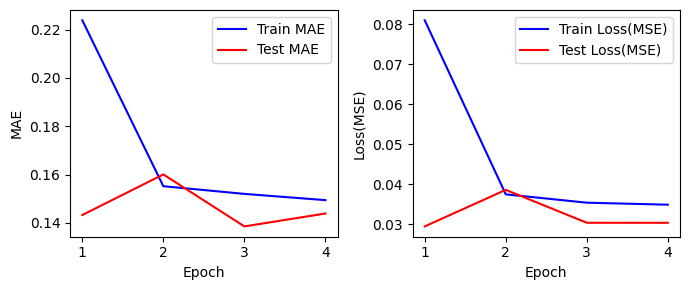

In [125]:
acc2 = history.history['mae']
val_acc = history.history['val_mae']
loss2 = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc2)+1)

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

axes[0].plot(epochs, acc2,'b',label='Train MAE')
axes[0].plot(epochs, val_acc,'r',label='Test MAE')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].legend()

axes[1].plot(epochs, loss2,'b',label='Train Loss(MSE)')
axes[1].plot(epochs, val_loss,'r',label='Test Loss(MSE)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss(MSE)')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [126]:
# Ensure y_test is a NumPy array (if it's a DataFrame or Series)
if isinstance(y_test, pd.DataFrame) or isinstance(y_test, pd.Series):
    y_test = y_test.values

# Ensure y_pred_ann is 1-dimensional
y_pred_lstm_flat = y_pred_lstm.flatten()

# Ensure y_test is also 1-dimensional if it isn't already
y_test_flat = y_test.flatten()

# Create a DataFrame to hold actual and predicted values
results_lstm = pd.DataFrame({'Actual SOH': y_test_flat, 'Predicted SOH': y_pred_lstm_flat.round(4)})

# Print the actual and predicted SOH values
print(results_lstm)

     Actual SOH  Predicted SOH
0        0.1231         0.2328
1        0.3744         0.2335
2        0.1782         0.2331
3        0.4869         0.2328
4        0.3438         0.6006
..          ...            ...
246      0.7323         0.6126
247      0.2741         0.2328
248      0.2306         0.2328
249      0.1856         0.2373
250      0.2840         0.2328

[251 rows x 2 columns]


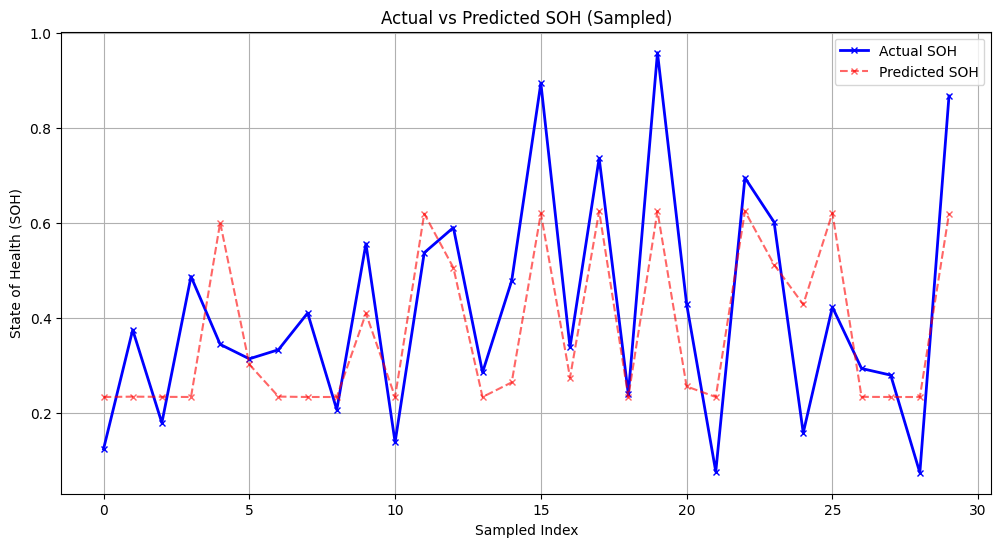

In [127]:
# Sample data for clearer visualization if the dataset is large
sample_size = 30  # adjust sample size as needed
y_test_sample = y_test[:sample_size]
y_pred_sample = y_pred_lstm[:sample_size]

y_pred_sample_flat = y_pred_sample.flatten()

# Plot actual and predicted SOH with transparency and markers
plt.figure(figsize=(12, 6))
plt.plot(y_test_sample, label='Actual SOH', color='blue',marker='x', markersize=5, linewidth=2)
plt.plot(y_pred_sample_flat, label='Predicted SOH', color='red', linestyle='--', marker='x', markersize=5, alpha=0.6)
plt.title('Actual vs Predicted SOH (Sampled)')
plt.xlabel('Sampled Index')
plt.ylabel('State of Health (SOH)')
plt.legend()
plt.grid(True)
plt.show()